In [ ]:
! pip install gpytorch

In [15]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def get_patches(x, kernel_size, stride):
    c = x.shape[1]
    patches = nn.Unfold(kernel_size=kernel_size, stride=stride)(x)
    s = math.sqrt(torch.prod(torch.Tensor(list(patches.shape))) // (c * kernel_size**2))
    s = int(s)
    patches = patches.reshape(1, c, kernel_size, kernel_size, s, s)
    return patches

def get_x_data(patch, kernel_size, stride):
    b, c, h, w = patch.shape
    x_data = nn.Unfold(kernel_size=kernel_size, stride=stride)(patch)
    s = math.sqrt(torch.prod(torch.Tensor(list(x_data.shape))) // (c * kernel_size**2))
    s = int(s)
    x_data = x_data.reshape(c, kernel_size, kernel_size, s, s)
    return x_data

def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])

def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)

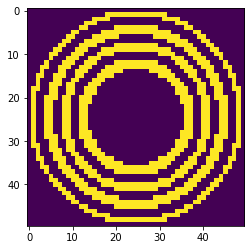

In [324]:
xx, yy = torch.meshgrid(torch.linspace(-1, 1, 50),torch.linspace(-1, 1, 50))
circle1 = (xx ** 2 + yy ** 2 < 1).unsqueeze(0).unsqueeze(0).float()
circle2 = -(xx ** 2 + yy ** 2 < .9).unsqueeze(0).unsqueeze(0).float()
circle3 = (xx ** 2 + yy ** 2 < .75).unsqueeze(0).unsqueeze(0).float()
circle4 = -(xx ** 2 + yy ** 2 < .6).unsqueeze(0).unsqueeze(0).float()
circle5 = (xx ** 2 + yy ** 2 < .5).unsqueeze(0).unsqueeze(0).float()
circle6 = -(xx ** 2 + yy ** 2 < .4).unsqueeze(0).unsqueeze(0).float()
circle7 = (xx ** 2 + yy ** 2 < .3).unsqueeze(0).unsqueeze(0).float()
circle8 = -(xx ** 2 + yy ** 2 < .2).unsqueeze(0).unsqueeze(0).float()

circle = circle1 + circle2 + circle3 + circle4 + circle5 + circle6 + circle7 + circle8
plt.imshow(circle[0].permute(1, 2, 0))

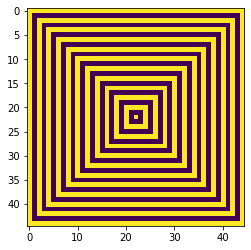

In [281]:
square = torch.zeros(45, 45)

val = 1
for i in range(45):
    square[i:45-i, i:45-i] = val
    val = 1 - val

square = square.unsqueeze(0).unsqueeze(0).float()

plt.imshow(square[0].permute(1, 2, 0))

In [ ]:
L = circle

preds = []
kernel_size = 20
stride = 10

patches_L = get_patches(L, kernel_size=kernel_size, stride=stride)

scale_factor = 10
Hb = nn.Upsample(scale_factor=scale_factor, mode='bicubic')(L)
Hb_patches = get_patches(Hb, kernel_size * scale_factor, stride=stride * scale_factor)

training_iter = 1000

for i in range(patches_L.shape[-1]):
    for j in range(patches_L.shape[-1]):
        print(i, j)
        patch_L = patches_L[..., i, j]
        training = get_x_data(patch_L, kernel_size=3, stride=3)

        Xnl = training.reshape(9, -1)
        y = Xnl[4, :]
        Xnl = torch.cat([Xnl[:4, :], Xnl[5:, :]], dim=0).permute(1, 0)

        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(Xnl, y, likelihood)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        for k in range(training_iter):
            optimizer.zero_grad()

            output = model(Xnl)

            loss = -mll(output, y).mean()

            loss.backward()
#             print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#                 k + 1, training_iter, loss.item(),
#                 model.covar_module.base_kernel.lengthscale.item(),
#                 model.likelihood.noise.item()
#             ))
            optimizer.step()
        
        
        Hb_patch = F.pad(Hb_patches[..., i, j], [1, 1, 1, 1])
        inference = get_x_data(Hb_patch, kernel_size=3, stride=1)
        Xnl = inference.reshape(9, -1)
        Xnl = torch.cat([Xnl[:4, :], Xnl[5:, :]], dim=0).permute(1, 0)

        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(Xnl))
        
        s = int(math.sqrt(observed_pred.loc.shape[-1]))
        preds.append(observed_pred.loc.reshape(s, s))

<ipython-input-267-250f540ffd97>:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  s = math.sqrt(torch.prod(torch.Tensor(list(patches.shape))) // (c * kernel_size**2))
<ipython-input-267-250f540ffd97>:23: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  s = math.sqrt(torch.prod(torch.Tensor(list(x_data.shape))) // (c * kernel_size**2))


0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


torch.Size([500, 500])


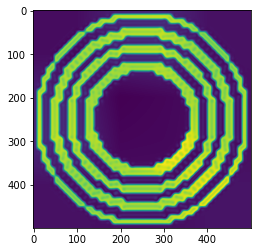

In [328]:
s = Hb_patches.shape[-1]
blended = blend(preds, overlap=(kernel_size - stride) * scale_factor, dims=(s, s))
print(blended.shape)
plt.imshow(blended.detach().cpu())

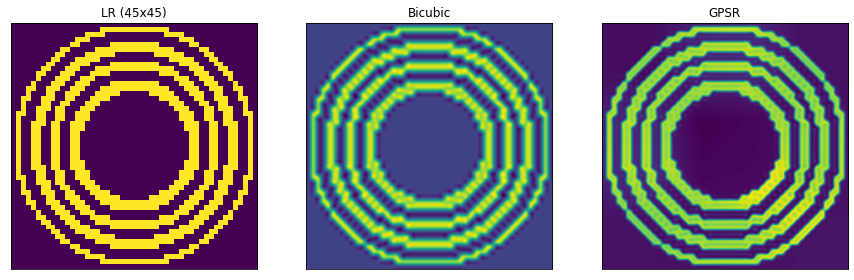

In [329]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(L.squeeze())
ax[1].imshow(Hb.squeeze())
ax[2].imshow(blended.detach().cpu().squeeze())

ax[0].set_title('LR (45x45)')
ax[1].set_title('Bicubic')
ax[2].set_title('GPSR')

remove_axes(ax)

## Blending

In [152]:
def blend_patch(x0, x1, overlap, direction):
    xh0, xw0 = x0.shape
    xh1, xw1 = x1.shape
    dim_to_overlap = xw0
    other_dim = xh0
    
    if direction == 'v':
        x0 = x0.permute(1, 0)
        x1 = x1.permute(1, 0)
        dim_to_overlap = xh0
        other_dim = xw0

    xramp0 = dim_to_overlap - overlap
    xramp1 = 0

    x00 = x0[:, :xramp0]
    x01 = x0[:, xramp0:]

    x11 = x1[:, :overlap]
    x12 = x1[:, overlap:]

    ramp0 = torch.linspace(1, 0, overlap).repeat((other_dim, 1))
    ramp1 = 1 - ramp0

    blend_mid = x01 * ramp0 + x11 * ramp1

    blend = torch.cat([x00, blend_mid, x12], dim=1)
    
    if direction == 'v':
        blend = blend.permute(1, 0)
    return blend


def blend(patches, overlap, dims):
    h, w = dims
    curr_blend = None
    
    for i in range(h):
        row_blend = patches[i * w]
        for j in range(1, w):
            if w == 0 and h == 0:
                continue
            
            idx = i * w + j

            next_patch = patches[idx]
            row_blend = blend_patch(row_blend, next_patch, overlap, 'h')

        if curr_blend is None:
            curr_blend = row_blend
        else:
            curr_blend = blend_patch(curr_blend, row_blend, overlap, 'v')
    return curr_blend

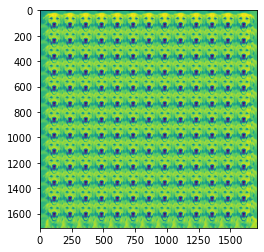

In [246]:
from torchvision import transforms as T

transform = T.Compose([
    T.Resize(224),
    T.ToTensor()
])

dog = transform(Image.open('dog.png').convert('L')).squeeze()

dogs = [dog for _ in range(36)]

plt.imshow(blend(dogs, 50, (6, 6)))

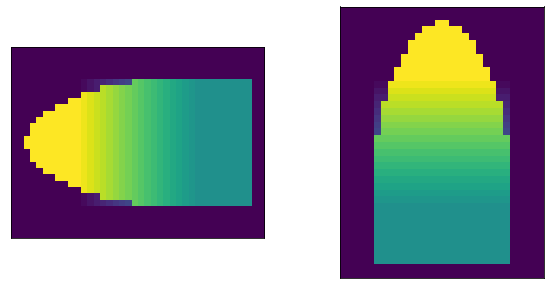

In [107]:
s = 30

xx, yy = torch.meshgrid(torch.linspace(-1, 1, s),torch.linspace(-1, 1, s))
circle = (xx ** 2 + ((yy - 1) ** 2)/7 < 0.5).float()
square = torch.zeros((s, s))
square[5:25, :28] = 0.5

circle = (yy ** 2 + ((xx - 1) ** 2)/7 < 0.5).float()
square = torch.zeros((s, s))
square[:28, 5:25] = 0.5

plt.imshow(blend(circle, square, 20, 'v'))